In [44]:
import sys
sys.path.insert(0, "../")
from chunkgfn.environment.fractalgrid import FractalGridModule
from chunkgfn.environment.bit_sequence import BitSequenceModule
from chunkgfn.environment.rna_binding import RNABindingModule
from chunkgfn.environment.graph import GraphGenerationModule
from chunkgfn.algo.tb_gfn import TBGFN
from chunkgfn.algo.a2c import A2C
from chunkgfn.algo.sac import SAC
from chunkgfn.algo.random_sampler import RandomSampler
from chunkgfn.algo.utils import has_trainable_parameters

from torch.distributions import Categorical
from scipy.stats import linregress, spearmanr
import networkx as nx
from einops import repeat, rearrange
from polyleven import levenshtein
from pathlib import Path
import pickle
import torch
from tqdm.notebook import tqdm
import lightning as L
from matplotlib.lines import Line2D
from scipy import stats
import matplotlib.pyplot as plt
from addict import Dict
import numpy as np
import wandb
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Some preliminary code

In [2]:
def calculate_mean_std(iteration_key, value_key, *dicts):
    key_value = {}
    all_iterations = set()
    for i, d in enumerate(dicts):
        iterations = d[iteration_key]
        values = d[value_key]

        key_value[i] = {k: v for (k,v) in zip(iterations, values)}
        all_iterations = all_iterations.union(set(iterations))
    
    all_iterations = sorted(all_iterations)
    mean = []
    std = []
    for i in all_iterations:
        values = [key_value[j][i]  for j in key_value if i in key_value[j]]
        mean.append(np.mean(values))
        std.append(np.std(values))
    return all_iterations, mean, std

def get_library_embeddings(sampler, env):
    """Produce embedding for all actions in the library.
    Returns:
        library_embeddings (torch.Tensor[n_actions, action_embedding]): Embeddings for all actions.
    """
    action_indices = env.action_indices
    library_embeddings = []
    for action, indices in action_indices.items():
        library_embeddings.append(
            sampler.action_embedder(
                torch.LongTensor(indices).to(sampler.device).unsqueeze(0)
            )
        )
    library_embeddings = torch.cat(library_embeddings, dim=0)
    return library_embeddings

def get_forward_logits(state: torch.Tensor, algo, env) -> torch.Tensor:
    """Get the forward logits for the given state.
    Args:
        state (torch.Tensor[batch_size, *state_shape]): State.
    Return:
        logits (torch.Tensor[batch_size, n_actions]): Forward logits.
    """
    if algo.forward_policy is None:
        bs = state.shape[0]
        logits = torch.zeros(bs, env.n_actions).to(state.device)
        return logits
    action_embedding = algo.forward_policy(env.preprocess_states(state))
    dim = action_embedding.shape[-1]
    library_embeddings = get_library_embeddings(algo, env)
    logits = torch.einsum("bd, nd -> bn", action_embedding, library_embeddings) / (
        dim**0.5
    )  # Same as in softmax
    return logits

def get_backward_logits(state: torch.Tensor, algo, env) -> torch.Tensor:
    """Get the forward logits for the given state.
    Args:
        state (torch.Tensor[batch_size, *state_shape]): State.
    Return:
        logits (torch.Tensor[batch_size, n_actions]): Forward logits.
    """
    processed = env.preprocess_states(state)
    if algo.backward_policy is not None and has_trainable_parameters(
        algo.backward_policy
    ):
        # If the backward policy is trainable, use action embeddings, otherwise,
        # don't use them and output logits directly.
        if isinstance(processed, tuple):
            action_embedding = algo.backward_policy(*processed)
        else:
            action_embedding = algo.backward_policy(processed)
        dim = action_embedding.shape[-1]
        library_embeddings = get_library_embeddings(algo, env)
        logits = torch.einsum(
            "bd, nd -> bn", action_embedding, library_embeddings
        ) / (dim**0.5)  # Same as in softmax
        return logits

    if isinstance(processed, tuple):
        logits = algo.backward_policy(*processed)
    else:
        logits = algo.backward_policy(processed)
    return logits

def kl(p, q):
    """
    Compute the Kullback-Leibler divergence between two discrete probability distributions p and q.
    Args:
        p (torch.Tensor): First discrete probability distribution of shape (n_samples).
        q (torch.Tensor): Second discrete probability distribution of shape (n_samples).
    Returns:
        kl_div (torch.Tensor): The Kullback-Leibler divergence between p and q.
    """
    
    # Compute the KL divergence
    kl_div = (p * torch.log(p / q)).sum()
    
    return kl_div
def jsd(p, q):
    """
    Compute the Jensen-Shannon divergence between two discrete probability distributions p and q.
    Args:
        p (torch.Tensor): First discrete probability distribution of shape (n_samples).
        q (torch.Tensor): Second discrete probability distribution of shape (n_samples).
    Returns:
        jsd_div (torch.Tensor): The Jensen-Shannon divergence between p and q.
    """

    
    # Compute the average distribution
    m = (p + q) / 2
    
    # Compute the KL divergence between p and m, and q and m
    kl_pm = kl(p, m)
    kl_qm = kl(q, m)
    
    # Compute the Jensen-Shannon divergence
    jsd_div = (kl_pm + kl_qm) / 2
    
    return jsd_div


In [3]:
def sample_trajectories(n_trajectories, sampler, env):
    with torch.no_grad():
        batch_size=n_trajectories
        s0 = env.s0.to(sampler.device)
        state = repeat(s0, " ... -> b ...", b=batch_size)
        bs = state.shape[0]

        # Start unrolling the trajectories
        actions = []
        trajectories = []
        dones = []
        done = torch.zeros((bs)).to(state).bool()
        trajectory_length = (
            torch.zeros((bs)).to(state).long()
        )  # This tracks the length of trajetcory for each sample in the batch
        while not done.all():
            logits_pf = get_forward_logits(state, sampler, env)
            valid_actions_mask = env.get_forward_mask(state)

            logits_pf = torch.where(
                valid_actions_mask,
                logits_pf,
                torch.tensor(-1e20).to(logits_pf),
            )


            cat = Categorical(logits=logits_pf)

            act = cat.sample()

            new_state, done = env.forward_step(state, act)
            trajectory_length += ~done  # Increment the length of the trajectory for each sample in the batch as long it's not done.

            actions.append(act)
            trajectories.append(state)
            dones.append(done.clone())

            state = new_state.clone()

        logreward = env.compute_logreward(state).to(
                state.device
        )
        trajectories.append(state)
        dones.append(torch.ones((bs)).to(state).bool())
        trajectories = torch.stack(trajectories, dim=1)
        actions = torch.stack(actions, dim=1)
        dones = torch.stack(dones, dim=1)

    return logreward, state, trajectories, dones, actions

In [4]:
def go_backward(final_state: torch.Tensor, sampler, env):
    """Sample backward trajectories conditioned on inputs.
    Args:
        final_state (torch.Tensor[batch_size, *state_shape]): Final state.
    Return:
        trajectories (torch.Tensor[batch_size, trajectory_length, *state_shape]): Trajectories for each sample in the batch.
        actions (torch.Tensor[batch_size, trajectory_length]): Actions for each sample in the batch.
        dones (torch.Tensor[batch_size, trajectory_length]): Whether the trajectory is done or not.
        state (torch.Tensor[batch_size, *state_shape]): Final state.
    """
    bs = final_state.shape[0]
    device = final_state.device
    state = final_state.clone()
    done = torch.zeros((bs), device=device, dtype=bool)

    # Start unrolling the trajectories
    actions = []
    trajectories = []
    dones = []
    dones.append(torch.ones((bs), device=device, dtype=bool))
    while not done.all():
        logit_pb = get_backward_logits(state, sampler, env)
        backward_mask = env.get_backward_mask(state)
        logit_pb = torch.where(
            backward_mask,
            logit_pb,
            torch.tensor(-1e20, device=device),
        )

        # When no action is available, just fill with uniform because
        # it won't be picked anyway in the backward_step.
        # Doing this avoids having nan when computing probabilities
        logit_pb = torch.where(
            (logit_pb == -torch.inf).all(dim=-1).unsqueeze(1),
            torch.tensor(0.0),
            logit_pb,
        )
        cat = Categorical(logits=logit_pb)

        act = cat.sample()

        new_state, done = env.backward_step(state, act)

        actions.append(act)
        trajectories.append(state)
        dones.append(done.clone())

        state = new_state.clone()

    trajectories.append(state)

    trajectories = torch.stack(trajectories[::-1], dim=1)
    actions = torch.stack(actions[::-1], dim=1)
    dones = torch.stack(dones[::-1], dim=1)

    return trajectories, actions, dones, final_state

def _get_ll(final_state: torch.Tensor, logreward: torch.Tensor, sampler, env, n_trajectories) -> torch.Tensor:
        """Get the log likelihood of the model for the given trajectories.
        Args:
            final_state (torch.Tensor[batch_size, *state_shape]): The examples for which we're computing the log-likelihood.
            logreward (torch.Tensor[batch_size]): Log reward.
        Return:
            log_pT (torch.Tensor[batch_size]): Log likelihood.
            trajectories (torch.Tensor[batch_size*n_trajectories, trajectory_length, *state_shape]): Trajectories for each sample in the batch.
            actions (torch.Tensor[batch_size*n_trajectories, trajectory_length]): Actions for each sample in the batch.
            dones (torch.Tensor[batch_size*n_trajectories, trajectory_length]): Whether the trajectory is done or not.
            logreward (torch.Tensor[batch_size*n_trajectories]): Log reward.
        """
        unique_final_state = final_state
        bs = unique_final_state.shape[0]
        device = final_state.device
        # Repeat the final_state n_trajectories times
        final_state = repeat(
            final_state, "b ... -> b n ...", n=n_trajectories
        )
        final_state = rearrange(final_state, "b n ... -> (b n) ...")
        logreward = repeat(logreward, "b -> b n", n=n_trajectories)
        logreward = rearrange(logreward, "b n ... -> (b n) ... ")
        trajectories, actions, dones, final_state = go_backward(final_state, sampler, env)

        # Calculate the log likelihood
        log_pf = 0
        log_pb = 0

        for t in range(trajectories.shape[1]):
            state = trajectories[:, t]
            logit_pf = get_forward_logits(state, sampler, env)
            forward_mask = env.get_forward_mask(state)
            logit_pf = torch.where(
                forward_mask,
                logit_pf,
                torch.tensor(-1e20, device=device),
            )

            if t < trajectories.shape[1] - 1:
                log_pf += (Categorical(logits=logit_pf).log_prob(actions[:, t])) * (
                    ~dones[:, t] + 0
                )

            if t > 0:
                logit_pb = get_backward_logits(state, sampler, env)
                backward_mask = env.get_backward_mask(state)

                logit_pb = torch.where(
                    backward_mask,
                    logit_pb,
                    torch.tensor(-1e20, device=device),
                )

                # When no action is available, just fill with uniform because
                # it won't be picked anyway in the backward_step.
                # Doing this avoids having nan when computing probabilities
                logit_pb = torch.where(
                    (logit_pb == -torch.inf).all(dim=-1).unsqueeze(1),
                    torch.tensor(0.0),
                    logit_pb,
                )
                log_pb += torch.where(
                    dones[:, t] | env.is_initial_state(state),
                    torch.tensor(0.0),
                    Categorical(logits=logit_pb).log_prob(actions[:, t - 1]),
                )

        log_pb = rearrange(log_pb, "(b n) ... -> b n ...", b=bs).to(final_state.device)
        log_pf = rearrange(log_pf, "(b n) ... -> b n ...", b=bs)
        logreward = rearrange(logreward, "(b n) ... -> b n ...", b=bs)

        assert log_pf.shape == log_pb.shape
        log_pT = torch.logsumexp(log_pf - log_pb, dim=1) - torch.log(
            torch.tensor(n_trajectories)
        )

        return log_pT, log_pf, log_pb, logreward

@torch.no_grad
def get_ll(final_state: torch.Tensor, logreward: torch.Tensor, sampler, env, n_trajectories, max_chunk_size=None):
    bs = final_state.shape[0]
    if max_chunk_size is None:
        max_chunk_size = final_state.shape[0]
    num_chunks = (
        bs + max_chunk_size - 1
    ) // max_chunk_size  # Calculate number of chunks

    log_pT = []
    log_pf = []
    log_pb = []
    logr = []
    for i in tqdm(range(num_chunks), leave=False):
        start_idx = i * max_chunk_size
        end_idx = min(start_idx + max_chunk_size, bs)

        # Extract the chunk
        final_state_chunk = final_state[start_idx:end_idx]
        logreward_chunk = logreward[start_idx:end_idx]

        # Compute loss for the chunk
        log_pT_chunk, log_pf_chunk, log_pb_chunk, logreward_chunk = _get_ll(
            final_state_chunk, logreward_chunk, sampler, env, n_trajectories
        )
        log_pT.append(log_pT_chunk)
        log_pf.append(log_pf_chunk)
        log_pb.append(log_pb_chunk)
        logr.append(logreward_chunk)
    
    log_pT = torch.cat(log_pT, dim=0)
    log_pf = torch.cat(log_pf, dim=0)
    log_pb = torch.cat(log_pb, dim=0)
    logr = torch.cat(logr, dim=0)

    return log_pT, log_pf, log_pb, logr

# Plotting params

In [5]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=12)  # legend fontsize
plt.rc("figure", titlesize=26)  # fontsize of the figure title
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update(
    {
        "font.serif": [
            "Computer Modern Roman",
            "Times New Roman",
            "Utopia",
            "New Century Schoolbook",
            "Century Schoolbook L",
            "ITC Bookman",
            "Bookman",
            "Times",
            "Palatino",
            "Charter",
            "serif" "Bitstream Vera Serif",
            "DejaVu Serif",
        ]
    }
)

In [6]:
algo_colors = {
    "GFN": "#CC6677",
    "A2C": "#E69F00",
    "Random Sampler": "#332288" ,
    "SAC": "#117733"
}

chunk_colors = {
    "No Chunk": "#648FFF",
    "Chunking Basic": "#DC267F",
    "Chunking w/ Replacement": "#FFB000"
}

chunk_ls = {
    "No Chunk": "dotted",
    "Chunking Basic": "dashed",
    "Chunking w/ Replacement": "solid"
}

# Wandb experiment fetching
This step requires internet connection and may take a while...

In [7]:
experiments = Dict()
env_task_variables = {
    "fractalgrid": "side_length",
    "bit_sequence": "max_len",
    "rna_binding": "task",
    "graph": "max_nodes"
}
for env in ["fractalgrid", "bit_sequence", "rna_binding", "graph"]:
    api = wandb.Api()
    runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"config.task_name": env, "tags": "absolute"})
    columns = ["_step", 'train/num_modes', 'train/num_visited', 'train/logreward', 'train/trajectory_length', 'trainer/global_step', "epoch"]
    
    for run in tqdm(runs, leave=False):
        name = run.name
        history = run.scan_history(keys=columns)
        summary = {}
        for row in history:
            for key in row.keys():
                if key not in summary:
                    summary[key] = []
                summary[key].append(row[key])
        summary["id"] = run.id
        config = run.config
        
        algo = config["algo"]["_target_"].lower()
        task = config["environment"][env_task_variables[env]]

        if "a2c" in algo:
            algorithm = "A2C"
        elif "tbgfn" in algo:
            if "compressor" not in name:
                algorithm = "GFN"
            else:
                alpha = config["algo"]["backward_policy"]["alpha"]
                if alpha == 0:
                    algorithm = "MaxEnt-GFN"
                else:
                    algorithm = "ShortParse-GFN"

        elif "random" in algo:
            algorithm = "Random Sampler"
        elif "sac" in algo:
            algorithm = "SAC"
        else:
            raise Exception("Can't recognize algorithm")
        
        if "chunk" not in name:
            chunk_type = "No Chunk"
        elif "chunk_replacement" in name:
            chunk_type = "Chunking w/ Replacement"
        elif "chunk" in name:
            chunk_type = "Chunking Basic"

        if len(experiments[env][task][algorithm][chunk_type]) == 0:
            experiments[env][task][algorithm][chunk_type] = [summary]
        else:
            experiments[env][task][algorithm][chunk_type].append(summary)

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

0it [00:00, ?it/s]

# Does chunking improve generative modeling?

## Chunking accelerates mode discovery

### FractalGrid
In FractalGrid, we focus on `side_length=257` for showcasing mode discovery in the main text. We'll start with the number of modes.

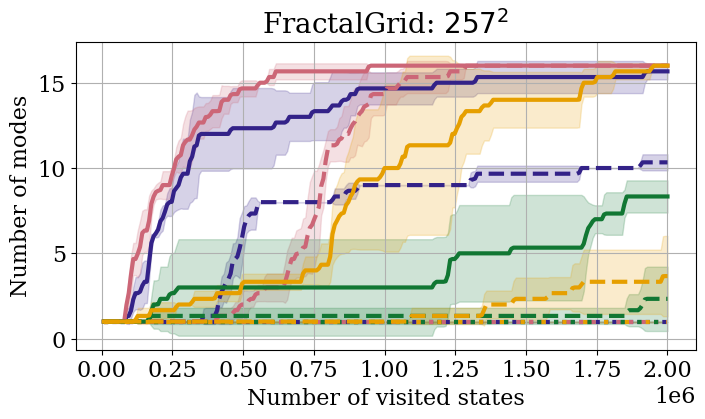

In [145]:
side_length = 257
fig, ax = plt.subplots(1,1,figsize=(8,4))
for i, algo in enumerate(experiments["fractalgrid"][side_length]):
    for chunk_type in experiments["fractalgrid"][side_length][algo]:
        if chunk_type in experiments["fractalgrid"][side_length][algo]:
            all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_modes", *experiments["fractalgrid"][side_length][algo][chunk_type])
            all_iterations = np.array(all_iterations)*64
            
        line, = ax.plot(all_iterations, mean, label=algo, color=algo_colors[algo], linestyle=chunk_ls[chunk_type], linewidth=3)
        if chunk_type == "No Chunk":
            line.set_dashes([1,1+i])
        ax.fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=algo_colors[algo], alpha=0.2)
    
ax.grid()
ax.set_xlabel("Number of visited states")
ax.set_ylabel("Number of modes")
legend_elements = [Line2D([0], [0], lw=2, color="black", linestyle=chunk_ls[chunk_type], label=chunk_type) for chunk_type in chunk_ls]
legend_elements += [Line2D([0], [0], lw=4, color=algo_colors[algo], label=algo) for algo in algo_colors]

#ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title(f"FractalGrid: ${side_length}^2$", fontsize=20)

plt.savefig(f"gen_modeling/mode_discovery/fractalgrid_{side_length}_modes.png", format='png', dpi=300, bbox_inches='tight')

Now, let's look at sampling quality.

In [8]:
logp_Ts = Dict()
losses = Dict()
logrs = Dict()
true_logzs = Dict()
JSD = Dict()
elbo = Dict()
iw_elbo = Dict()
L1_distance = Dict()
number_of_trajectories = {
    "No Chunk": 15,
    "Chunking Basic": 15,
    "Chunking w/ Replacement": 15
}

for side_length in [65,129,257]:
    coordinates = np.meshgrid(np.arange(side_length), np.arange(side_length))
    coordinates = np.array(coordinates).T.reshape(-1, 2)
    coordinates = torch.from_numpy(coordinates)
    coordinates = torch.cat([coordinates, torch.ones(coordinates.shape[0], 1)], dim=-1).long()

    for algo in ["GFN"]:
        for chunk_type in tqdm(["No Chunk", "Chunking Basic", "Chunking w/ Replacement"]):
            run_id = experiments["fractalgrid"][side_length][algo][chunk_type][0]["id"]
            
            sampler = TBGFN.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/fractalgrid/runs/{run_id}/checkpoints/last.ckpt")
            env = FractalGridModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/fractalgrid/runs/{run_id}/checkpoints/last.ckpt")
            env.action_len = env.action_len.long()
            sampler.forward_policy.set_environment(env)
            sampler.backward_policy.set_environment(env)

            val_states = coordinates.to(sampler.device)
            val_logr = env.compute_logreward(coordinates).to(sampler.device)
            
            log_pT, log_pf, log_pb, logr = get_ll(val_states, val_logr, sampler, env, number_of_trajectories[chunk_type], max_chunk_size=2_000)
            
            
            
            log_pf = rearrange(log_pf, "b n ... -> (b n) ...")
            log_pb = rearrange(log_pb, "b n ... -> (b n) ...")
            logr = rearrange(logr, "b n ... -> (b n) ...")

            losses_ = (sampler.logZ+log_pf - log_pb - logr/sampler.hparams.reward_temperature)**2
            losses_ = losses_.detach().cpu()

            logp_Ts[side_length][algo][chunk_type] = log_pT.cpu()
            losses[side_length][algo][chunk_type] = losses_.cpu()
            logrs[side_length][algo][chunk_type] = logr.cpu()

            log_r = rearrange(logr, "(b n) ... -> b n ...", n=number_of_trajectories[chunk_type]).mean(1)
            true_p = (log_r/sampler.hparams.reward_temperature).softmax(0)
            learned_p = (log_pT).softmax(0)
            
            # Sampling metrics
            JSD[side_length][algo][chunk_type] = jsd(true_p, learned_p)
            L1_distance[side_length][algo][chunk_type] = (true_p-learned_p).abs().mean()
            
            sampled_logreward, sampled_states, _, _, _ = sample_trajectories(20_000, sampler, env)
            _, log_pf, log_pb, logr = get_ll(sampled_states, sampled_logreward, sampler, env, 1, max_chunk_size=2_000)
            elbo[side_length][algo][chunk_type] = (logr/sampler.hparams.reward_temperature + log_pb - log_pf).mean()
            
            true_logzs[side_length][algo][chunk_type] = torch.logsumexp((env.grid).log()/sampler.hparams.reward_temperature, dim=(0,1))

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_embedder'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'backward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

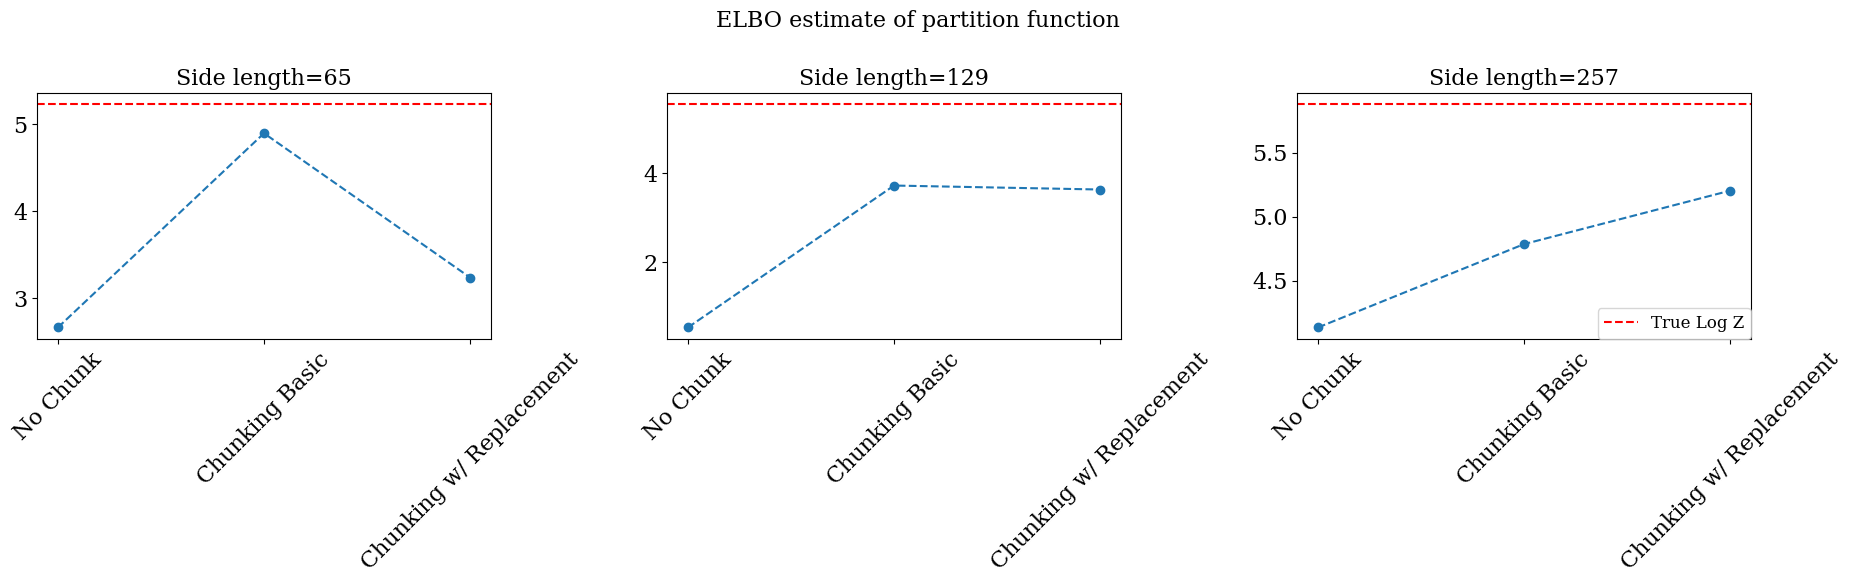

In [38]:
fig, ax = plt.subplots(1,3,figsize=(19,6))
for i, side_length in enumerate(elbo):
   elbo_ = []
   chunk_types = []
   true_logz = []
   for chunk_type in elbo[side_length]["GFN"]:
      elbo_.append(elbo[side_length]["GFN"][chunk_type].item())
      true_logz.append(true_logzs[side_length]["GFN"][chunk_type].item())
      chunk_types.append(chunk_type)
   ax[i].plot(range(3), elbo_, marker="o", linestyle="dashed")
   ax[i].set_xticks(range(3))
   ax[i].set_xticklabels(chunk_types, rotation=45)
   ax[i].set_title(f"Side length={side_length}")
   ax[i].axhline(y=np.mean(true_logz), color='r', linestyle='--', label='True Log Z')

ax[-1].legend(loc='lower right', borderaxespad=0.)
fig.suptitle('ELBO estimate of partition function', fontsize=16)
fig.tight_layout()


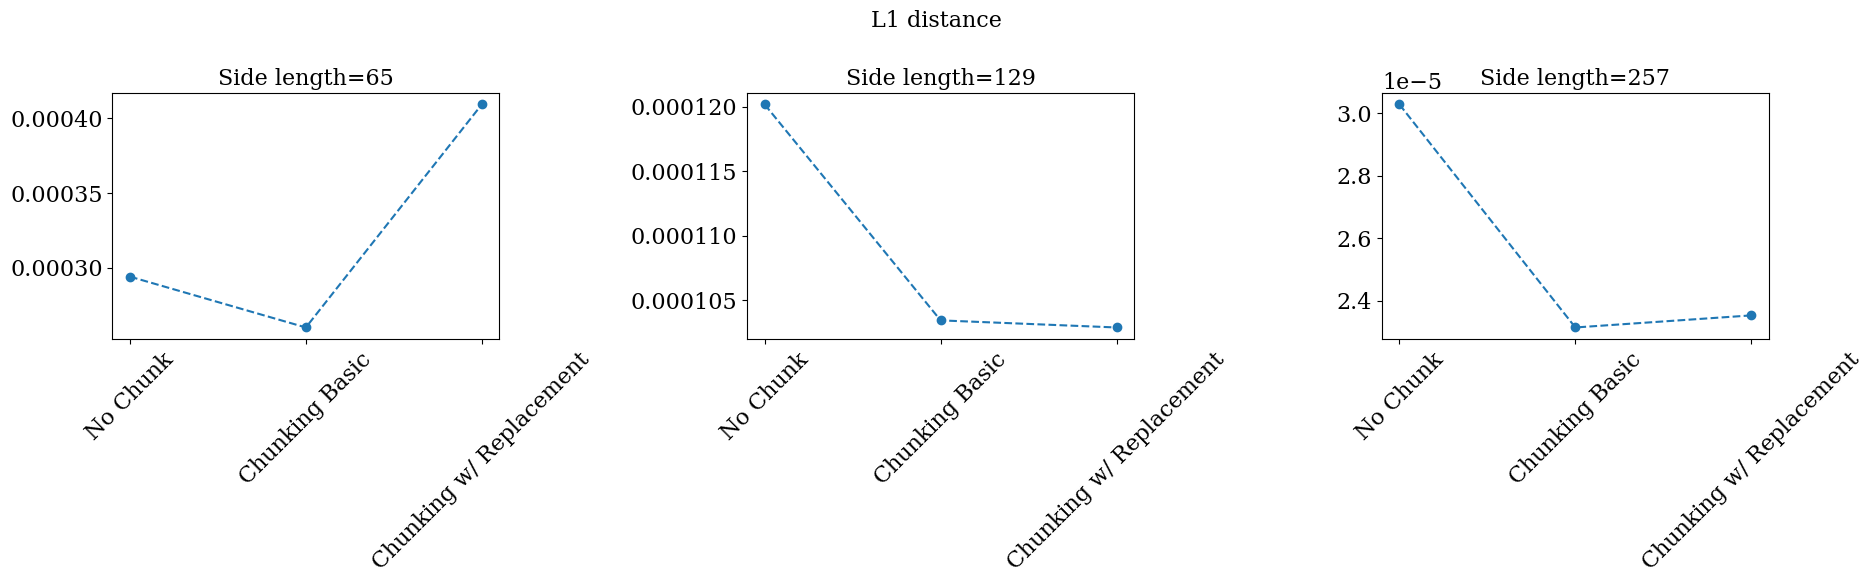

In [41]:
fig, ax = plt.subplots(1,3,figsize=(19,6))
for i, side_length in enumerate(elbo):
   l1d = []
   chunk_types = []
   for chunk_type in elbo[side_length]["GFN"]:
      l1d.append(L1_distance[side_length]["GFN"][chunk_type].item())
      chunk_types.append(chunk_type)
   ax[i].plot(range(3), l1d, marker="o", linestyle="dashed")
   ax[i].set_xticks(range(3))
   ax[i].set_xticklabels(chunk_types, rotation=45)
   ax[i].set_title(f"Side length={side_length}")

fig.suptitle('L1 distance', fontsize=16)
fig.tight_layout()


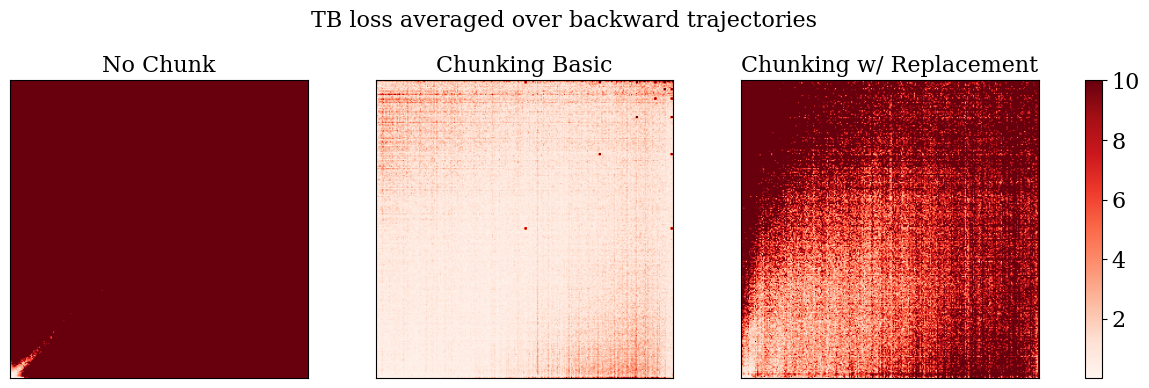

In [86]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # 3 plots and 1 colorbar
# Create the subplots
im = []
for i, chunk_type in enumerate(losses["GFN"]):
    ax = fig.add_subplot(gs[i])  # Add subplot in the grid
    losses_ = rearrange(losses["GFN"][chunk_type], "(b n) ... -> b n ...", n=number_of_trajectories[chunk_type]).mean(-1)
    losses_ = rearrange(losses_, "(h w) -> h w", h=side_length)
    losses_ = torch.clip(losses_, max=10)

    # Add images to subplots
    im_ = ax.imshow(losses_, origin='lower', cmap="Reds")
    im.append(im_)

    # Set title and remove ticks
    ax.set_title(chunk_type)
    ax.set_xticks([])
    ax.set_yticks([])

# Add a colorbar to the right of the subplots
cax = fig.add_subplot(gs[3])  # Use the last grid cell for the colorbar
fig.colorbar(im[0], cax=cax)  # Use the first imshow plot for the colorbar
fig.suptitle('TB loss averaged over backward trajectories', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

### Bit Sequence

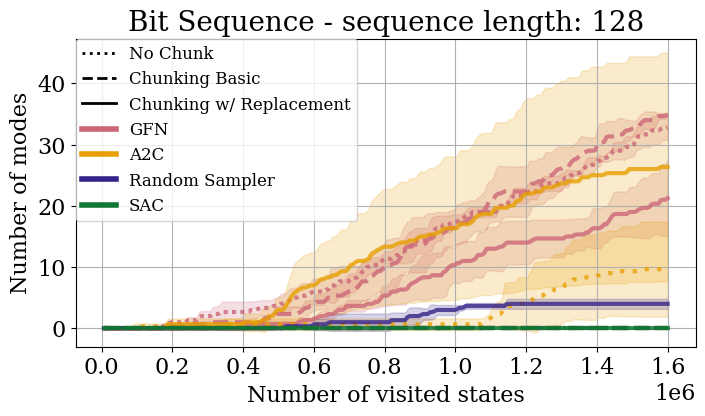

In [146]:
max_len = 128
fig, ax = plt.subplots(1,1,figsize=(8,4))
for i, algo in enumerate(algo_colors):
    for chunk_type in experiments["bit_sequence"][max_len][algo]:
        if chunk_type in experiments["bit_sequence"][max_len][algo]:
            all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_modes", *experiments["bit_sequence"][max_len][algo][chunk_type])
            all_iterations = np.array(all_iterations)*64
            
        line, = ax.plot(all_iterations, mean, label=algo, color=algo_colors[algo], linestyle=chunk_ls[chunk_type], alpha=0.8, linewidth=3)
        if chunk_type == "No Chunk":
            line.set_dashes([1,1+i])
        ax.fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=algo_colors[algo], alpha=0.2)
    
ax.grid()
ax.set_xlabel("Number of visited states")
ax.set_ylabel("Number of modes")
legend_elements = [Line2D([0], [0], lw=2, color="black", linestyle=chunk_ls[chunk_type], label=chunk_type) for chunk_type in chunk_ls]
legend_elements += [Line2D([0], [0], lw=4, color=algo_colors[algo], label=algo) for algo in algo_colors]

ax.legend(handles=legend_elements, loc='upper left', borderaxespad=0.)
ax.set_title(f"Bit Sequence - sequence length: {max_len}", fontsize=20)
plt.savefig(f"gen_modeling/mode_discovery/bit_sequence_{max_len}_modes.png", format='png', dpi=300, bbox_inches='tight')

### RNA Binding

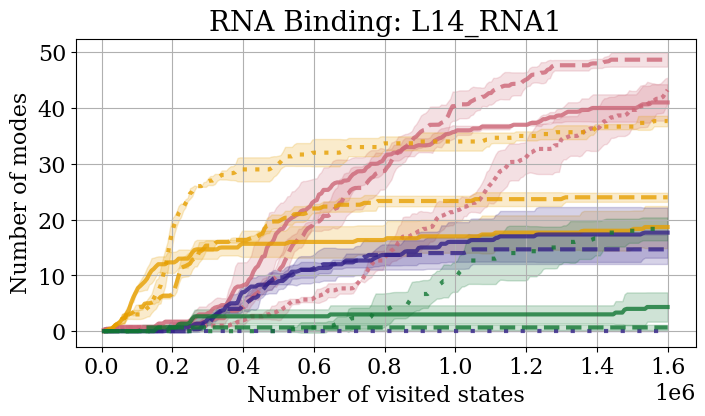

In [42]:
task = "L14_RNA1"
fig, ax = plt.subplots(1,1,figsize=(8,4))
for i, algo in enumerate(algo_colors):
    for chunk_type in experiments["rna_binding"][task][algo]:
        if chunk_type in experiments["rna_binding"][task][algo]:
            all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_modes", *experiments["rna_binding"][task][algo][chunk_type])
            all_iterations = np.array(all_iterations)*64
            
        line, = ax.plot(all_iterations, mean, label=algo, color=algo_colors[algo], linestyle=chunk_ls[chunk_type], alpha=0.8, linewidth=3)
        if chunk_type == "No Chunk":
            line.set_dashes([1,1+i])
        ax.fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=algo_colors[algo], alpha=0.2)
    
ax.grid()
ax.set_xlabel("Number of visited states")
ax.set_ylabel("Number of modes")
legend_elements = [Line2D([0], [0], lw=2, color="black", linestyle=chunk_ls[chunk_type], label=chunk_type) for chunk_type in chunk_ls]
legend_elements += [Line2D([0], [0], lw=4, color=algo_colors[algo], label=algo) for algo in algo_colors]

#ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title(f"RNA Binding: {task}", fontsize=20)

plt.savefig(f"gen_modeling/mode_discovery/{task}_modes.png", format='png', dpi=300, bbox_inches='tight')

In [70]:
logp_Ts = Dict()
losses = Dict()
logrs = Dict()
true_logzs = Dict()
JSD = Dict()
elbo = Dict()
iw_elbo = Dict()
L1_distance = Dict()
number_of_trajectories = {
    "No Chunk": 1,
    "Chunking Basic": 10,
    "Chunking w/ Replacement": 10
}

for task in ["L14_RNA1"]:
    for algo in ["GFN"]:
        for chunk_type in tqdm(["No Chunk", "Chunking Basic", "Chunking w/ Replacement"]):
            run_id = experiments["rna_binding"][task][algo][chunk_type][0]["id"]
            
            sampler = TBGFN.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
            env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
            env.action_len = env.action_len.long()
            sampler.forward_policy.set_environment(env)
            sampler.backward_policy.set_environment(env)

            val_states = env.data_val.sequences.to(sampler.device)
            val_logr = env.data_val.logrewards.to(sampler.device)
            val_states = val_states[val_logr>=torch.log(torch.tensor(0.9))]
            val_logr = val_logr[val_logr>=torch.log(torch.tensor(0.9))]
            
            log_pT, log_pf, log_pb, logr = get_ll(val_states, val_logr, sampler, env, number_of_trajectories[chunk_type], max_chunk_size=2_000)
            
            
            log_pf = rearrange(log_pf, "b n ... -> (b n) ...")
            log_pb = rearrange(log_pb, "b n ... -> (b n) ...")
            logr = rearrange(logr, "b n ... -> (b n) ...")

            losses_ = (sampler.logZ+log_pf - log_pb - logr/sampler.hparams.reward_temperature)**2
            losses_ = losses_.detach().cpu()

            logp_Ts[task][algo][chunk_type] = log_pT.cpu()
            losses[task][algo][chunk_type] = losses_.cpu()
            logrs[task][algo][chunk_type] = logr.cpu()

            log_r = rearrange(logr, "(b n) ... -> b n ...", n=number_of_trajectories[chunk_type]).mean(1)
            
            # Sampling metrics
            
            sampled_logreward, sampled_states, _, _, _ = sample_trajectories(10_000, sampler, env)
            _, log_pf, log_pb, logr = get_ll(sampled_states, sampled_logreward, sampler, env, 1, max_chunk_size=2_000)
            elbo[task][algo][chunk_type] = (logr/sampler.hparams.reward_temperature + log_pb - log_pf).mean()

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_embedder'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'backward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [71]:
elbo

{'L14_RNA1': {'GFN': {'No Chunk': tensor(11.0391, device='cuda:0'),
   'Chunking Basic': tensor(11.0311, device='cuda:0'),
   'Chunking w/ Replacement': tensor(10.9715, device='cuda:0')}}}

In [75]:
losses["L14_RNA1"]["GFN"]["Chunking Basic"].mean()

tensor(0.0185)

In [76]:
losses["L14_RNA1"]["GFN"]["No Chunk"].mean()

tensor(0.0118)

In [77]:
losses["L14_RNA1"]["GFN"]["Chunking w/ Replacement"].mean()

tensor(0.3715)